In [4]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image as im
from PIL import ImageChops as ic
import random as rd
import _pickle as cPickle

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


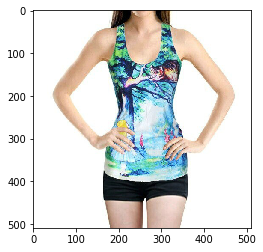

In [5]:
img=plt.imread('train_images/1001.jpg')
imgplot = plt.imshow(img)

In [6]:
top_ten_labels = np.array([66, 105, 153, 17, 171, 106, 222, 214, 53, 62])

In [7]:
labels_file = open('train_images/labels.csv', 'r') 
labels = labels_file.readlines()
for i in range(len(labels)):
    labels[i] = np.array(labels[i].split(','))
    labels[i] = labels[i][:228]

In [8]:
labels = np.array(labels)
labels = labels[:,top_ten_labels]

In [9]:
labels.shape

(10000, 10)

In [25]:
update_inception_features = False
IMAGE_SIZE = 10000

TEST_SIZE = 8000

In [16]:
imgArray=[]
 #Change depending on what input your CNN expects

for j in range(1,IMAGE_SIZE+1):
    if j % 1000 == 0:
        print("Finished " + str(j) + " Images")
    imgName = 'train_images/' + str(j) +'.jpg'
    img = im.open(imgName).convert("RGB")
    imgArray.append(np.array(img))



Finished 1000 Images
Finished 2000 Images
Finished 3000 Images
Finished 4000 Images
Finished 5000 Images
Finished 6000 Images
Finished 7000 Images
Finished 8000 Images
Finished 9000 Images
Finished 10000 Images


In [26]:
#X_train = np.array(imgArray[:TEST_SIZE])
y_train = np.array(labels[: TEST_SIZE])

#X_test = np.array(imgArray[TEST_SIZE: IMAGE_SIZE])
y_test = np.array(labels[TEST_SIZE:IMAGE_SIZE])

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)

print(len(X_train))


NameError: name 'X_train' is not defined

In [11]:
import keras
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc
import os
import math

Using TensorFlow backend.


In [12]:
# load inceptionV3 model + remove final classification layers
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(139, 139, 3))
print('model loaded')


model loaded


In [15]:

# obtain bottleneck features (train)
if os.path.exists('inception_features_train.npz') and not update_inception_features:
    print('bottleneck features detected (train)')
    features = np.load('inception_features_train.npz')['features']
else:
    print('bottleneck features file not detected (train)')
    print('calculating now ...')
    # pre-process the train data
    print(X_train.shape)
    big_X_train = np.array([scipy.misc.imresize(X_train[i], (139, 139, 3)) 
                            for i in range(0, len(X_train))]).astype('float32')
    inception_input_train = preprocess_input(big_X_train)
    print(X_train.shape)
    print('train data preprocessed')
    # extract, process, and save bottleneck features
    features = model.predict(inception_input_train)
    features = np.squeeze(features)
    np.savez('inception_features_train', features=features)
    
print('bottleneck features saved (train)')
print(features.shape)

bottleneck features detected (train)
bottleneck features saved (train)
(8000, 3, 3, 2048)


In [16]:

if os.path.exists('inception_features_test.npz')  and not update_inception_features:
    print('bottleneck features detected (test)')
    features_test = np.load('inception_features_test.npz')['features_test']
else:
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_X_test = np.array([scipy.misc.imresize(X_test[i], (139, 139, 3)) 
                       for i in range(0, len(X_test))]).astype('float32')
    inception_input_test = preprocess_input(big_X_test)
    # extract, process, and save bottleneck features (test)
    features_test = model.predict(inception_input_test)
    features_test = np.squeeze(features_test)
    np.savez('inception_features_test', features_test=features_test)
print('bottleneck features saved (test)')

bottleneck features detected (test)
bottleneck features saved (test)


In [17]:
print(features.shape)

(8000, 3, 3, 2048)


In [ ]:
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(filters=30, kernel_size=3, input_shape=features.shape[1:]))
print(model.output.shape)
model.add(Dropout(0.4))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.3))
model.add(Dense(30, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))
print(model.output.shape)
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.best.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(features, y_train, batch_size=50, epochs=50,
          validation_split=0.1, callbacks=[checkpointer],
          verbose=2, shuffle=True)



(?, 1, 1, 30)
(?, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 1, 1, 30)          552990    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 1, 30)          0         
_________________________________________________________________
global_max_pooling2d_4 (Glob (None, 30)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_11 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [21]:
pred = model.predict(features_test[0:1])

lst = pred[0].argsort()[::-1][:10]


In [22]:
[i for i in range(300) if y_test[0, i] == str(1)] 

NameError: name 'y_test' is not defined

In [ ]:
def compute_f1_score(x_hat, y):
    
    
    
    